In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def plotFaceShape(shape):
    plt.plot(shape[0:15, 0], shape[0:15, 1])
    plt.plot(shape[0:15, 0], shape[0:15, 1], 'bo')
    
    plt.plot(shape[15:21,0], shape[15:21, 1], 'g')
    plt.plot(shape[15:21,0], shape[15:21, 1], 'go')
    plt.plot(shape[21:27,0], shape[21:27, 1], 'g')
    plt.plot(shape[21:27,0], shape[21:27, 1], 'go')
    
    plt.plot(shape[27:31,0], shape[27:31, 1], 'r')
    plt.plot(shape[27:31,0], shape[27:31, 1], 'ro')
    plt.plot(shape[32:36,0], shape[32:36, 1], 'r')
    plt.plot(shape[32:36,0], shape[32:36, 1], 'ro')
    plt.plot(shape[68:72,0], shape[68:72, 1], 'r')
    plt.plot(shape[68:72,0], shape[68:72, 1], 'ro')
    plt.plot(shape[72:76,0], shape[72:76, 1], 'r')
    plt.plot(shape[72:76,0], shape[72:76, 1], 'ro')
    

    plt.plot(shape[37:46,0], shape[37:46, 1], 'y')
    plt.plot(shape[37:46,0], shape[37:46, 1], 'yo')

    plt.plot(shape[48:60,0], shape[48:60, 1], 'c')
    plt.plot(shape[48:60,0], shape[48:60, 1], 'co')
    plt.plot(shape[60:66,0], shape[60:66, 1], 'c')
    plt.plot(shape[60:66,0], shape[60:66, 1], 'co')
    
    extra_points = np.array([31,36,66,67])
    plt.plot(shape[extra_points,0], shape[extra_points,1], 'y*')
    

**Procrustes Analysis:**

  1. Translate each example such that its  centroid is at origin, and scale them so that $|\mathbf{x}|=1$
  2. Choose the first example as the initial estimate of the mean shape ($\bar{\mathbf{x}}$), and save a copy as a reference ($\mathbf{\bar{x}_0}$)
  3. Align all the examples with the current estimate of the mean ($\bar{\mathbf{x}}$)
  4. Re-estimate mean from the aligned shapes
  5. Apply constraints on the current estiate of the mean by aligning it with reference $\mathbf{\bar{x}_0}$ and scaling so that $|\bar{\mathbf{x}}|=1$
  6. Repeat steps 3, 4, 5 until convergence

In [2]:
import pandas

df = pandas.read_csv('muct76-opencv.csv', header=0, usecols=np.arange(2,154), dtype=float)

df.head()

,x00,y00,x01,y01,x02,y02,x03,y03,x04,y04,...,x71,y71,x72,y72,x73,y73,x74,y74,x75,y75
0,201.0,348.0,201.0,381.0,202.0,408.0,209.0,435.0,224.0,461.0,...,235.5,348.5,338.0,333.5,324.0,335.5,326.0,342.5,340.0,340.5
1,162.0,357.0,157.0,387.0,160.0,418.0,167.0,446.0,182.0,477.0,...,202.5,359.0,305.5,346.0,291.5,348.0,292.0,354.5,306.0,352.5
2,212.0,352.0,203.0,380.0,200.0,407.0,211.0,439.0,224.0,479.0,...,257.5,355.0,344.5,343.5,334.0,345.0,335.0,351.0,345.5,349.5
3,157.0,316.0,155.0,348.0,154.0,373.0,159.0,407.0,172.0,435.0,...,192.0,319.0,295.5,311.5,280.0,313.0,282.0,320.0,297.5,318.5
4,201.0,373.0,200.0,408.0,203.0,433.0,213.0,463.0,226.0,481.0,...,237.0,377.5,335.5,366.5,322.0,369.0,324.5,375.0,338.0,372.5


In [3]:
X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

d = np.hstack((X,Y))
d.shape

(7510, 152)

In [4]:
import sys
threshold = 1.0e-8

def center(vec):
    pivot = int(vec.shape[0]/2)
    meanx = np.mean(vec[:pivot])
    meany = np.mean(vec[pivot:])
    return(meanx, meany)

def calnorm(vec):
    vsqsum = np.sum(np.square(vec))
    return(vsqsum)

def scale(vec):
    vcopy = vec.copy()
    vmax = np.max(vec)
    if vmax > 2.0:
        vcopy = vcopy / vmax
    vnorm = calnorm(vcopy)
    return (vcopy / np.sqrt(vnorm))

def caldiff(pref, pcmp):
    return np.mean(np.sum(np.square(pref - pcmp), axis=1))

def simTransform(pref, pcmp, showerror = False):
    err_before = np.mean(np.sum(np.square(pref - pcmp), axis=1))
    ref_mean = np.mean(pref, axis=0)
    prefcentered = np.asmatrix(pref) - np.asmatrix(ref_mean)
    
    cmp_mean = np.mean(pcmp, axis=0)
    pcmpcentered = np.asmatrix(pcmp) - np.asmatrix(cmp_mean)   
    
    Sxx = np.sum(np.square(pcmpcentered[:,0]))
    Syy = np.sum(np.square(pcmpcentered[:,1]))
    Sxxr = prefcentered[:,0].T * pcmpcentered[:,0] #(ref_x, x)
    Syyr = prefcentered[:,1].T * pcmpcentered[:,1] #(ref_y, y)
    Sxyr = prefcentered[:,1].T * pcmpcentered[:,0] #(ref_y, x)
    Syxr = prefcentered[:,0].T * pcmpcentered[:,1] #(ref_x, y)
    a = (Sxxr + Syyr)/(Sxx + Syy) #(Sxxr + Syyr) / (Sxx + Syy)
    b = (Sxyr - Syxr) / (Sxx + Syy)
    a = np.asscalar(a)
    b = np.asscalar(b)
    Rot = np.matrix([[a, -b],[b, a]])
    translation = -Rot * np.asmatrix(cmp_mean).T + np.asmatrix(ref_mean).T
    outx, outy = [], []
    res = Rot * np.asmatrix(pcmp).T + translation
    err_after = np.mean(np.sum(np.square(pref - res.T), axis=1))

    if showerror:
        print("Error before: %.4f    after: %.4f\n"%(err_before, err_after))
    return (res.T, err_after)
    
    
def align2mean(data):
    d = data.copy()
    pivot = int(d.shape[1]/2)
    for i in range(d.shape[0]):
        cx, cy = center(d[i,:])
        d[i,:pivot] = d[i,:pivot] - cx
        d[i,pivot:] = d[i,pivot:] - cy
        #print(cx, cy, center(d[i,:]))
        d[i,:] = scale(d[i,:])
        norm = calnorm(d[i,:])
    
    d_aligned = d.copy()
    pref = np.vstack((d[0,:pivot], d[0,pivot:])).T
    print(pref.shape)
    mean = pref.copy()

    mean_diff = 1
    while mean_diff > threshold:
        err_sum = 0.0
        for i in range(1, d.shape[0]):
            p = np.vstack((d[i,:pivot], d[i,pivot:])).T
            p_aligned, err = simTransform(mean, p)
            d_aligned[i,:] = scale(p_aligned.flatten(order='F'))
            err_sum += err
        
        oldmean = mean.copy()
        mean = np.mean(d_aligned, axis=0)
        mean = scale(mean)
        mean = np.reshape(mean, newshape=pref.shape, order='F')
        d = d_aligned.copy()
        mean_diff = caldiff(oldmean, mean)
        sys.stdout.write("SumError: %.4f MeanDiff: %.6f\n"%(err_sum, mean_diff))

    return (d_aligned, mean)
        
    
d_aligned, mean = align2mean(d)

(76, 2)
SumError: 13.0966 MeanDiff: 0.000236
SumError: 11.9712 MeanDiff: 0.000000
SumError: 11.9718 MeanDiff: 0.000000


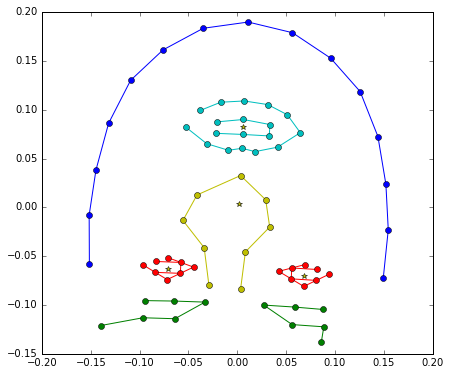

In [5]:
plt.figure(figsize=(7,7))
plt.gca().set_aspect('equal')
plotFaceShape(mean)

## PCA

In [12]:
d.shape

(7510, 152)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)

pca.fit(d)

PCA(copy=True, n_components=8, whiten=False)

In [9]:
print(pca.explained_variance_ratio_) 

[ 0.4383744   0.35125796  0.07912673  0.04544631  0.01696776  0.01432577
  0.01050875  0.00897217]


In [15]:
cov_mat = np.cov(d.T)
print(cov_mat.shape)

eig_values, eig_vectors = np.linalg.eig(cov_mat)
print(eig_values.shape, eig_vectors.shape)

(152, 152)
(152,) (152, 152)


In [16]:
num_eigs = 8
Phi_matrix = eig_vectors[:,:num_eigs]

Phi_matrix.shape

(152, 8)

In [18]:
mean.dump('models/meanshape-ocvfmt.pkl')
eig_vectors.dump('models/eigenvectors-ocvfmt.pkl')
eig_values.dump('models/eigenvalues-ocvfmt.pkl')